<a href="https://colab.research.google.com/github/AmirMoazzami/266_final_proj/blob/mk%2Fkmeans-extraction-conclusion-only/extraction_exploration/longt5_with_conclusion_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Main idea: extract conclusions manually, put through abstractive summarization.

***Extractive step: BERT, K means***

In [ ]:
import typing

from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.cluster import KMeans
from datasets import load_dataset
import pandas as pd
from pprint import pprint


# Load the dataset and cut down to the first 5 for demonstration
full_dataset = load_dataset("allenai/mslr2022", "ms2", split='train')
dataset = full_dataset.select(range(3))  # Use select to create a subset

# Initialize BERT
bert_model_to_use = "dmis-lab/biobert-v1.1"
tokenizer = BertTokenizer.from_pretrained(bert_model_to_use)
model = BertModel.from_pretrained(bert_model_to_use)

/Users/michaelenghoekhor/Downloads/pytorch-test/env/lib/python3.8/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [6]:
def clean_text(text):
    """Clean text:
    - replace line breaks (\n) with spaces
    - replace " r and om" with "random" -- this word lemma occurs a lot in medical text!
    - same with "st and ard" -> "standard"
    - replace " ed " with "ed " -- past tense verbs are often separated from the word stem in this dataset
    - remove text "( ABSTRACT TRUNCATED" and everything after it, if it exists
    """
    text = text.replace('\n', ' ')
    text = text.replace(' r and om', ' random')
    text = text.replace(' st and ard', ' standard')
    text = text.replace(' ed ', 'ed ')
    if '( ABSTRACT TRUNCATED' in text:
        text = text[:text.index('( ABSTRACT TRUNCATED')]
    return text

def split_sentences(text):
    """From one abstract, split into sentences and return a list of sentences."""
    return text.split(' . ')


def bert_sentence_embeddings(sentences: typing.List[str]):
    inputs = tokenizer(sentences, return_tensors='pt', max_length=512, truncation=True, padding=True)
    with torch.no_grad():
        embeddings = model(**inputs)
    # embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    # return np.array(embeddings)
    return embeddings.last_hidden_state.mean(dim=1).numpy()


def cluster_kmeans(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)
    return kmeans, cluster_labels
    top_sentence_indices = np.argmin(
        np.linalg.norm(embeddings[:, np.newaxis] - kmeans.cluster_centers_, axis=2),
        axis=0,
    )
    top_sentences = [sentences[index] for index in sorted(top_sentence_indices)]
    return ' '.join(top_sentences)

# def process_row(row):
#     review_id = row['review_id']
#     abstract_list = row['abstract']

#     combined_summary = ''

#     for abstract in abstract_list:
#         # Check if the abstract is a string; if not, join it into a single string
#         abstract_text = ' '.join(abstract) if isinstance(abstract, list) else abstract

#         # Split abstract into sentences
#         sentences = abstract_text.split('. ')
#         # Generate embeddings for each sentence
#         embeddings = bert_sentence_embeddings(sentences)
#         # Select the top sentences from these embeddings
#         summary = select_top_sentences(sentences, embeddings)

# #         # Print the top sentences for debugging
#         print("Top sentences for this abstract:", summary)


#         # Combine the summaries from each abstract
#         combined_summary += summary + ' '

#     return {"review_id": review_id, "summary": combined_summary.strip()}


In [ ]:
# test
example_idx = 0
abstract_idx = 1
test_row = dataset[example_idx]
abstract = test_row['abstract'][abstract_idx]
clean_abstract = clean_text(abstract)
print("original:", abstract)
print("clean   :", clean_abstract)

test_split_sentences = split_sentences(clean_abstract)
print("split   :", test_split_sentences)


# split for all abstracts, concatenate into a single list while keeping track of which abstract idx it came from
all_split_sentences = []
abstract_idx_to_sentence_idx = []
for abstract_idx, abstract in enumerate(test_row['abstract']):
    clean_abstract = clean_text(abstract)
    one_abstract_split_sentences = split_sentences(clean_abstract)
    all_split_sentences.extend(one_abstract_split_sentences)
    abstract_idx_to_sentence_idx.extend([abstract_idx] * len(one_abstract_split_sentences))

# print with abstract idx per new line; only for first 3 abstracts
for abstract_idx, sentence in zip(abstract_idx_to_sentence_idx, all_split_sentences):
    if abstract_idx > 2:
        break
    print(f"{abstract_idx:2d}:", sentence)

test_embeddings = bert_sentence_embeddings(all_split_sentences)
print("avg'ed embeddings shape:", test_embeddings.shape)

# Also get the embedding for the background
test_background_embedding = bert_sentence_embeddings([clean_text(test_row["background"])])[0]
print(f"{test_background_embedding.shape=}")

# Apply the function to each element of the dataset
# summaries_dataset = dataset.map(process_row)

# Convert to pandas DataFrame
# df = pd.DataFrame(summaries_dataset)
# df = df[['review_id', 'summary']]
# Save to CSV
# csv_file_path = 'test.csv'  # Update with your desired file path
# df.to_csv(csv_file_path, index=True)

# print(f"Saved summaries to {csv_file_path}")

original: Abstract We investigated the effect of adipose-derived stem cells ( ADSCs ) transplantation effects on structural remodeling and pulmonary artery pressure in  monocrotaline (MCT)-induced pulmonary hypertensive rats . In the first experiment , 32 male Sprague-Dawley ( SD ) rats were r and omly divided into four groups ( n = 8/group ) : 3 ADSCs treated groups and normal control ( Ctrl ) . ADSCs were administered through the left jugular vein at 105 , 106 and 107 cells , respectively , and a cell density of 106cells/ml was shown to be optimal . The GFP-tagged ADSCs were identified in the lungs and differentiated into endothelial-like cells . In the second experiment , 96 male SD rats were r and omly divided into three groups ( n = 32/group ) : Ctrl , MCT-induced pulmonary arterial hypertension ( PAH ) , and PAH treated with ADSCs ( ADSCs ) . Two weeks post-MCT administration , the ADSCs group received 1 × 106 ADSCs via the external jugular vein . Compared to PAH rats , mean pulm

In [ ]:
pprint(test_row["background"])

('Background Despite significant progress in drug treatment , the prognosis of '
 'patients with advanced pulmonary arterial hypertension ( PAH ) remains '
 'extremely poor .\n'
 'Many pre clinical studies have reported the efficacy of stem cell ( SC ) '
 'therapy for PAH ; however , this approach remains controversial .\n'
 'The aim of this systematic review and meta- analysis is to assess the '
 'potential efficacy of SC therapy for PAH .')


In [5]:
objective_words = ["objective", "goal", "aim", "purpose"]
# [b for b in full_dataset["background"] if not (any(o in b.lower() for o in objective_words))]

In [7]:
# full_dataset["abstract"][0]

In [ ]:
# NOTE: some abstracts are truncated and have the text ABSRACT TRUNCATED at the end -- these should be removed

# [[b for b in a if "conclusion" not in b.lower()] for a in full_dataset["abstract"][:1]]
[[b for b in a if "abstract truncated" in b.lower()] for a in full_dataset["abstract"][:20]]
# [b for a in full_dataset["abstract"] for b in a if "abstract truncated" in b.lower()]

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ["We have investigated the role of aluminized metal foil ( space blanket , UN 320 ) , used pre-emptively , in post-anaesthetic  shivering and patients ' subjective perception of cold after general anaesthesia of short duration . Sixty-eight ASA I and II patients undergoing orthopaedic and plastic surgery on the peripheries were allocated r and omly to two groups : those in group 1 were wrapped ( not less than 60 % of body surface area ) in the space blanket before induction of anaesthesia . In group 2 patients had st and ard surgical draping . In all subjects , anaesthesia was induced with fentanyl and propofol , and maintained with nitrous oxide and enflurane in oxygen , after a laryngeal mask airway was positioned . Patients were asked to grade their perception of cold on a visual analogue scale , before induction and on recovery . Skin ( dorsum of h and ) and core ( nasopharyngeal ) temperatures were recorded at 15-mi

In [ ]:
# Experiment: use a QA model to rephrase background text as a question
from transformers import pipeline

# qa_model = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")
qa_model = pipeline("question-answering", model="deepset/roberta-large-squad2")

# Question: what is the background?
# context = test_row["background"]
context = "The objective of this review is to evaluate the efficacy of oral cobalamin treatment in elderly patients ."
question = "What is a likely conclusion of this study?"
result = qa_model(question=question, context=context)
print(f"{result=}")

result={'score': 0.018638228997588158, 'start': 35, 'end': 104, 'answer': 'evaluate the efficacy of oral cobalamin treatment in elderly patients'}


In [ ]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
context = test_row["background"]
# context = "The objective of this review is to evaluate the efficacy of oral cobalamin treatment in elderly patients ."
question = "In conclusion, we found that"
context_length = len(context.split())
generator(context + ". " + question, max_length=context_length + 50, num_return_sequences=5)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Background Despite significant progress in drug treatment , the prognosis of patients with advanced pulmonary arterial hypertension ( PAH ) remains extremely poor .\nMany pre clinical studies have reported the efficacy of stem cell ( SC ) therapy for PAH ; however , this approach remains controversial .\nThe aim of this systematic review and meta- analysis is to assess the potential efficacy of SC therapy for PAH .. In conclusion, we found that 1-hydroxytryptamine (1HT) therapy was superior to placebo for both the primary and treatment of PAH and it was particularly useful following the short-term'},
 {'generated_text': 'Background Despite significant progress in drug treatment , the prognosis of patients with advanced pulmonary arterial hypertension ( PAH ) remains extremely poor .\nMany pre clinical studies have reported the efficacy of stem cell ( SC ) therapy for PAH ; however , this approach remains controversial .\nThe aim of this systematic review and meta- 

In [ ]:
test_kmeans, test_cluster_labels = cluster_kmeans(test_embeddings, 3)
print(test_kmeans.cluster_centers_)

for abstract_idx, sentence, cluster_label in zip(abstract_idx_to_sentence_idx, all_split_sentences, test_cluster_labels):
    if abstract_idx > 5:
        break
    print(f"abs {abstract_idx:2d}: clus {cluster_label:2d}:", sentence)


[[-0.03913197 -0.08717724  0.03830195 ...  0.04546279  0.10905725
  -0.14598805]
 [-0.13268995 -0.14975166 -0.05916374 ... -0.09789731  0.14748567
  -0.05868191]
 [-0.07005733 -0.05044009 -0.05239785 ...  0.04523812  0.01784303
  -0.04808953]]
abs  0: clus  1: Although transplantation of adult bone marrow mesenchymal stem cells ( BM-MSCs ) holds promise in the treatment for pulmonary arterial hypertension ( PAH ) , the poor survival and differentiation potential of adult BM-MSCs have limited their therapeutic efficiency
abs  0: clus  1: Here , we compared the therapeutic efficacy of human embryonic stem cell-derived MSCs ( hESC-MSCs ) with adult BM-MSCs for the treatment of PAH in an animal model
abs  0: clus  1: One week following monocrotaline (MCT)-induced PAH , mice were randomly assigned to receive phosphate-buffered saline ( MCT group ) ; 3.0 × 106 human BM-derived MSCs ( BM-MSCs group ) or 3.0 × 106 hESC-derived MSCs ( hESC-MSCs group ) via tail vein injection
abs  0: clus  0: A

Text(0, 0.5, 'Silhouette score')

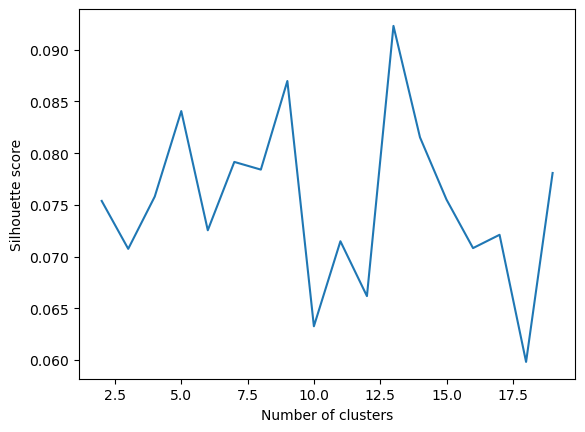

In [ ]:
# construct an elbow test to find the optimal number of clusters
from sklearn.metrics import silhouette_score

def get_silhouette_score(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    return silhouette_avg

get_silhouette_score(test_embeddings, 10)

# how to interpret the silhouette score? https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# plot the silhouette score for different numbers of clusters
import matplotlib.pyplot as plt
import matplotlib.cm as cm

silhouette_scores = []
n_clusters_range = range(2, 20)
for n_clusters in n_clusters_range:
    silhouette_scores.append(get_silhouette_score(test_embeddings, n_clusters))

plt.plot(n_clusters_range, silhouette_scores)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")

In [ ]:
# Alternative approach: calculate distance from background embedding
# test_background_embedding = bert_sentence_embeddings([clean_text(test_row["background"])])[0]
hack_text = "In conclusion, we found that 1-hydroxytryptamine (1HT) therapy was superior to placebo for both the primary and treatment of PAH and it was particularly useful following the short-term"
# hack_text = "In conclusion, the treatment had a positive effect"
# hack_text = "In conclusion, the treatment had no significant effect"
test_background_embedding = bert_sentence_embeddings([clean_text(hack_text)])[0]  # hack

test_distances = np.linalg.norm(test_embeddings - test_background_embedding, axis=1)
print(test_distances.shape)

# print per abstract: sorted by distance. also print abstract idx and distance
# for abstract_idx, sentence, distance in zip(abstract_idx_to_sentence_idx, all_split_sentences, test_distances):
#     if abstract_idx > 5:
#         break
#     print(f"abs {abstract_idx:2d}: dist {distance:2.2f}:", sentence)

for abstract_idx in range(5):
    # only get sentences from this abstract along with their distances
    abstract_distances = test_distances[np.array(abstract_idx_to_sentence_idx) == abstract_idx]
    abstract_sentences = np.array(all_split_sentences)[np.array(abstract_idx_to_sentence_idx) == abstract_idx]

    # get top sentences' indices
    top_sentence_indices = np.argsort(abstract_distances)[:3]

    # print all sentences in order with their distances. If it's a top sentence, mark it with a *
    for sentence_idx, (sentence, distance) in enumerate(zip(abstract_sentences, abstract_distances)):
        if sentence_idx in top_sentence_indices:
            print(f"abs {abstract_idx:2d}: dist {distance:2.2f}: *", sentence)
        else:
            print(f"abs {abstract_idx:2d}: dist {distance:2.2f}:  ", sentence)

    print("---")


(161,)
abs  0: dist 4.50: * Although transplantation of adult bone marrow mesenchymal stem cells ( BM-MSCs ) holds promise in the treatment for pulmonary arterial hypertension ( PAH ) , the poor survival and differentiation potential of adult BM-MSCs have limited their therapeutic efficiency
abs  0: dist 4.69: * Here , we compared the therapeutic efficacy of human embryonic stem cell-derived MSCs ( hESC-MSCs ) with adult BM-MSCs for the treatment of PAH in an animal model
abs  0: dist 4.89:   One week following monocrotaline (MCT)-induced PAH , mice were randomly assigned to receive phosphate-buffered saline ( MCT group ) ; 3.0 × 106 human BM-derived MSCs ( BM-MSCs group ) or 3.0 × 106 hESC-derived MSCs ( hESC-MSCs group ) via tail vein injection
abs  0: dist 4.40: * At 3 weeks posttransplantation , the right ventricular systolic pressure ( RVSP ) , degree of RV hypertrophy , and medial wall thickening of pulmonary arteries were lower= , and pulmonary capillary density was higher in th

In [ ]:
# Simplest "model" -- follow the procedure for each abstract after sentence splitting:
# 1. Does the abstract contain the word "conclusion"? If so, get the sentence with the word "conclusion" in it and everything after it.
# 2. Otherwise, get the last two sentences.

def extract_simple(sentences: typing.List[str]) -> typing.List[typing.Tuple[int, str]]:
    """two step process. Return sentences to keep and their indices."""

    concluding_words = ["conclusion", "conclud"]
    for sentence in sentences:
        if any(c in sentence.lower() for c in concluding_words):
            return [(s_idx, s) for s_idx, s in enumerate(sentences) if s_idx >= sentences.index(sentence)]

    return [(s_idx, s) for s_idx, s in enumerate(sentences) if s_idx >= len(sentences) - 2]

# test
test_extracted_sentences = []
for abstract_idx, abstract in enumerate(test_row['abstract']):
    test_extracted_sentences.append(extract_simple(split_sentences(clean_text(abstract))))

# prepare for abstractive summarization: concatenate all sentences into a single string

for abstract_idx, extracted_sentences in enumerate(test_extracted_sentences):
    print(f"abs {abstract_idx:2d}:", extracted_sentences)

abs  0: [(8, 'We concluded that improved cell survival and paracrine capacity of hESC-MSCs provide better therapeutic efficacy than BM-MSCs in the treatment for PAH')]
abs  1: [(7, 'Meanwhile , the right heart hypertrophy index ( 36.2 1 ± 4.27 % versus 41.01 ± 1.29 % ; 39.47 ± 4.02 % versus 48.75 ± 2 .13 % ; 41.02 ± 0.9 % versus 50.52 ± 1.49 % , p < 0.05 , respectively ) , ratio of wall/lumen thickness , as well as the wall/lumen area were significantly reduced in PAH rats at these time points following ADSCs-treatment , as compared with untreated PAH rats'), (8, 'In summary , ADSCs may colonize the pulmonary arteries , attenuate pulmonary arterial hypertension and ameliorate pulmonary arterial remodeling')]
abs  2: [(3, 'Two weeks post-operation , our results demonstrated that sublingual vein injection of BMSCs significantly attenuated the pulmonary vascular structural and hemodynamic changes caused by pulmonary arterial hypertension'), (4, 'The mechanism may be executed via paracrine

***abstractive step***

In [ ]:
import gc
import os
from transformers import AutoTokenizer, LongT5ForConditionalGeneration
from datasets import load_dataset
import pandas as pd
import torch
from torch.cuda.amp import autocast

# Memory optimization for CUDA
max_split_size_mb = 256  # Set the max_split_size_mb value (e.g., 512 MB)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = f"max_split_size_mb:{max_split_size_mb}"
print(f"PYTORCH_CUDA_ALLOC_CONF is set to: {os.environ['PYTORCH_CUDA_ALLOC_CONF']}")
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("mps")
print("device:", device)

# Load LongT5 Model and Tokenizer
# model_to_use = "google/long-t5-local-base"
model_to_use = "pszemraj/long-t5-tglobal-base-16384-book-summary"  # fined-tuned for summarization
longt5_model = LongT5ForConditionalGeneration.from_pretrained(model_to_use).to(device)
longt5_tokenizer = AutoTokenizer.from_pretrained(model_to_use)

# Assuming the longt5_tokenizer and longt5_model are already correctly initialized

batch_size = 1  # this is my limit in Google Colab T4 before I start getting OOM issues
max_token_length = 16384  # truly the limit of LongT5, but can reduce by multiples of 2 to optimize for speed if needed

# Try summarizing a single review only -- from test_extracted_sentences
batch_abstracts = [". ".join([". ".join([s[1] for s in a]) for a in test_extracted_sentences])]
val_inputs = longt5_tokenizer.batch_encode_plus(
    batch_abstracts,
    return_tensors="pt",
    max_length=max_token_length,
    truncation=True,
    padding=True,
    return_attention_mask=True,
).to(device)
print(f"{val_inputs['input_ids']=}")

# Generate summaries
summary_ids = longt5_model.generate(
    val_inputs["input_ids"],
    attention_mask=val_inputs["attention_mask"],
    max_new_tokens=512,
)

# Decode summaries
batch_summaries = longt5_tokenizer.batch_decode(
    summary_ids,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=True
)

print(batch_summaries)


PYTORCH_CUDA_ALLOC_CONF is set to: max_split_size_mb:256
device: mps


/Users/michaelenghoekhor/Downloads/pytorch-test/env/lib/python3.8/site-packages/transformers/models/longt5/modeling_longt5.py:74: UserWarning: MPS: The constant padding of more than 3 dimensions is not currently supported natively. It uses View Ops default implementation to run. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Pad.mm:474.)
  x = nn.functional.pad(x, pad=pad, mode="constant", value=pad_value)
/Users/michaelenghoekhor/Downloads/pytorch-test/env/lib/python3.8/site-packages/transformers/modeling_utils.py:861: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


['In this study, we report on the efficacy of hescpscs in treating patients with plethylin-induced pulmonary hypertensity. We also show that adsorption of bmsc into the lungs attenuates the thromolysis and improves right heart hypertension. This is an important finding because it suggests that BMsc may be more effective than hESCs for treating pah.']


In [ ]:
val_inputs["input_ids"].shape

torch.Size([1, 1012])

In [ ]:
print("background:")
pprint(test_row["background"])
print("")
print("target:")
pprint(test_row["target"])
print("")
print("generated summary:")
pprint(batch_summaries[0])

background:
('Background Despite significant progress in drug treatment , the prognosis of '
 'patients with advanced pulmonary arterial hypertension ( PAH ) remains '
 'extremely poor .\n'
 'Many pre clinical studies have reported the efficacy of stem cell ( SC ) '
 'therapy for PAH ; however , this approach remains controversial .\n'
 'The aim of this systematic review and meta- analysis is to assess the '
 'potential efficacy of SC therapy for PAH .')

target:
('Conclusions SC therapy is effective for PAH in pre clinical studies .\n'
 'These results may help to st and ardise pre clinical animal studies and '
 'provide a theoretical basis for clinical trial design in the future .')

generated summary:
('In this study, we report on the efficacy of hescpscs in treating patients '
 'with plethylin-induced pulmonary hypertensity. We also show that adsorption '
 'of bmsc into the lungs attenuates the thromolysis and improves right heart '
 'hypertension. This is an important finding becau

## For entire validation set for evaluation

In [3]:
!pip install -q datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Do the same but now for all of validation split

import os
import typing
import gc
import warnings

from tqdm import tqdm
from datasets import load_dataset
import numpy as np
import pandas as pd
from pprint import pprint
import torch
from transformers import AutoTokenizer, LongT5ForConditionalGeneration


warnings.filterwarnings("ignore", message=".*output with one or more elements was resized.*")
warnings.filterwarnings("ignore", message=".*the `device` argument is deprecated.*")

# Load the dataset
full_val_dataset = load_dataset("allenai/mslr2022", "ms2", split='validation')
# val_dataset = full_val_dataset.select(range(3))  # Use select to create a subset
val_dataset = full_val_dataset  # Use this to run on the full dataset

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("device:", device)

# set up save dir
# save_dir = "results_longt5_conclusion_only"
save_dir = "/content/drive/MyDrive/266: NLP/266 final project/extractive_abstractive/longt5_with_conclusion_only_results"
os.makedirs(save_dir, exist_ok=True)

# EXTRACTIVE "SUMMARIZATION"

def extract_simple(sentences: typing.List[str]) -> typing.List[typing.Tuple[int, str]]:
    """two step process. Return sentences to keep and their indices."""

    concluding_words = ["conclusion", "conclud"]
    for sentence in sentences:
        if any(c in sentence.lower() for c in concluding_words):
            return [(s_idx, s) for s_idx, s in enumerate(sentences) if s_idx >= sentences.index(sentence)]

    return [(s_idx, s) for s_idx, s in enumerate(sentences) if s_idx >= len(sentences) - 2]

# split for all abstracts, concatenate into a single list while keeping track of which abstract idx it came from
val_extracted_sentences: typing.Dict[str, typing.List[typing.Tuple[int, str]]] = {}
# dict (key: review_id) of lists (abstracts) of tuples (sentence_idx, sentence)
for review_id, abstracts_list in zip(val_dataset["review_id"], val_dataset["abstract"]):
    review_id = typing.cast(str, review_id)
    abstracts_list = typing.cast(typing.List[str], abstracts_list)
    val_extracted_sentences[review_id] = []
    for abstract_idx, abstract in enumerate(abstracts_list):
        clean_abstract = clean_text(abstract)
        one_abstract_split_sentences = split_sentences(clean_abstract)
        val_extracted_sentences[review_id].append(extract_simple(one_abstract_split_sentences))

# ABSTRACTIVE SUMMARIZATION

# Load LongT5 Model and Tokenizer

# Memory optimization for CUDA
if torch.cuda.is_available():
    max_split_size_mb = 256  # Set the max_split_size_mb value (e.g., 512 MB)
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = f"max_split_size_mb:{max_split_size_mb}"
    print(f"PYTORCH_CUDA_ALLOC_CONF is set to: {os.environ['PYTORCH_CUDA_ALLOC_CONF']}")
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Load LongT5 Model and Tokenizer
model_to_use = "pszemraj/long-t5-tglobal-base-16384-book-summary"  # fined-tuned for summarization
longt5_model = LongT5ForConditionalGeneration.from_pretrained(model_to_use).to(device)
longt5_tokenizer = AutoTokenizer.from_pretrained(model_to_use)

batch_size = 2
max_token_length = 8192  # 16384 is the limit of LongT5, but can reduce by multiples of 2 to optimize for speed if needed
prefix = "summarize conclusion concisely: "

all_summaries_embedding = []
all_batched_summaries = []
for i in tqdm(range(0, len(val_extracted_sentences), batch_size), ncols=70):
    # skip if all reviews in this batch are already summarized and saved in save_dir
    if all(os.path.exists(os.path.join(save_dir, f"{review_id}.txt")) for review_id in list(val_extracted_sentences.keys())[i:i+batch_size]):
        continue

    # create slice
    batch_review_ids = list(val_extracted_sentences.keys())[i:i+batch_size]
    batch_extracted_sentences = [val_extracted_sentences[review_id] for review_id in batch_review_ids]
    batch_concatenated_sentences = []
    for review_id, extracted_sentences in zip(batch_review_ids, batch_extracted_sentences):  # per review
        background_text = val_dataset["background"][val_dataset["review_id"].index(review_id)]
        batch_concatenated_sentences.append(
            prefix
            + ". ".join([". ".join([study_tuple[1] for study_tuple in study]) for study in extracted_sentences])
            + ". " + clean_text(background_text)
        )

    val_inputs = longt5_tokenizer.batch_encode_plus(
        batch_concatenated_sentences,
        return_tensors="pt",
        max_length=max_token_length,
        truncation=True,
        padding=True,
        return_attention_mask=True,
    ).to(device)

    # Generate summaries
    with torch.no_grad():
        summary_ids = longt5_model.generate(
            val_inputs["input_ids"],
            attention_mask=val_inputs["attention_mask"],
            max_new_tokens=256,
            num_beams=4,  # default: 2
        )

    # Decode summaries
    batch_summaries = longt5_tokenizer.batch_decode(
        summary_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )
    all_batched_summaries.extend(batch_summaries)

    # pprint(batch_summaries, width=150)

    # save to file
    for review_id, summary in zip(batch_review_ids, batch_summaries):
        with open(os.path.join(save_dir, f"{review_id}.txt"), "w") as f:
            f.write(summary)

    # clear memory
    del val_inputs
    del summary_ids
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        torch.mps.empty_cache()
    gc.collect()

device: cuda
PYTORCH_CUDA_ALLOC_CONF is set to: max_split_size_mb:256


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.36k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

100%|█████████████████████████████| 1011/1011 [45:02<00:00,  2.67s/it]


In [26]:
val_inputs["input_ids"].shape

torch.Size([1, 9054])

In [13]:
n = len(all_batched_summaries)
for bg, trgt, gen in zip(val_dataset["background"][:n], val_dataset["target"][:n], all_batched_summaries):
    print("background:")
    pprint(bg)
    print("")
    print("generated summary:")
    pprint(clean_text(gen))
    print("")
    print("target:")
    pprint(clean_text(trgt))
    print("---")
    print("")


background:
('Necrotizing enterocolitis ( NEC ) is one of the most serious '
 'gastrointestinal emergencies in very low birth weight ( VLBW ) preterm '
 'neonates , affecting 7 - 14 % of these neonates .\n'
 'Due to the seriousness of the disease , prevention of NEC is the most '
 'important goal .')

generated summary:
('Preterm infants with a low birth weight were compared to controls in terms '
 'of the severity of their morbidity and survival. The results suggest that '
 'prebiotics may be useful for reducing the risk of infection in premature '
 'infants.')

target:
('Current evidence from systematic review and meta- analysis revealed that '
 'probiotics are the most promising intervention in reduction of the incidence '
 'of NEC in VLBW neonates . As per the evidence , prebiotics modulate the '
 'composition of human intestine microflora to the benefit of the host by '
 'suppression of colonization of harmful microorganism and /or the stimulation '
 'of bifidobacterial growth , d

Now that it's done, concatenate all into a convenient csv with review ID and candidate (generate summary)

In [6]:
import pandas as pd
import os
from tqdm import tqdm

save_dir = "/content/drive/MyDrive/266: NLP/266 final project/extractive_abstractive/longt5_with_conclusion_only_results"

df = pd.DataFrame(columns=["review_id", "candidate"])
for file_count, filename in tqdm(enumerate(os.listdir(save_dir)), ncols=100):
    if filename.endswith(".txt"):
        with open(os.path.join(save_dir, filename), "r") as f:
            summary = f.read()

        df = pd.concat(
            [
                df,
                pd.DataFrame(
                    [[filename[:-4], summary]],
                    columns=["review_id", "candidate"]
                )
            ],
            ignore_index=True,
        )

df.to_csv(os.path.join(save_dir, "longt5_with_conclusion_only_validation.csv"), index=False)

2021it [22:58,  1.47it/s]


In [11]:
print(df.shape)
print(df.candidate.str.len().median())
df.head()

(2021, 2)
506.0


,review_id,candidate
0,26762372,This paper focuses on the protective role of a...
1,28723736,"In this paper, Caius uses a case-control study..."
2,22002191,"Conclusions In this paper, we present the resu..."
3,31921439,High intensity interval training is superior t...
4,30301735,"In this paper, the authors present a cost-effe..."
